HHU Deep Learning, WS2023/24, 24.11.2023

Lecture: Prof. Dr. Markus Kollmann

Exercises: Nikolas Adaloglou, Felix Michels

# Assignment 7 - Convolutional Neural Networks in medical image classification

---

Submit the solved notebook (not a zip) with your full name plus assignment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise, you will receive **2** point for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 08.12.2023 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/uAOgn8nTNMgeBC6](https://uni-duesseldorf.sciebo.de/s/uAOgn8nTNMgeBC6)

---

We will use the infamous `medmnist` dataset that contains multiple low-resolution medical imaging datasets for experimentation.

You can install it locally via `pip install medmnist` or in google colab with `!pip install medmnist`. To visualize the confusion matrix we suggest using seaborn, it can be install via pip.



You will learn how to perform training on the GPU. For this exercise, we highly reccomend using the free GPU resources from [https://colab.research.google.com](https://colab.research.google.com)


PS: for the confusion matrix you may use seaborn. You can install it via pip.

# 1. The story

There exists a model that is deployed, which scores around 80% test accuracy in the bloodmnist dataset.

Our aim is to create a better model that scores around 90% test accuracy.

Your task is to build and train a convolutional network (convnet) classification model for this purpose.

Note: This time we also got a test set, so 3 data splits in total. We will **only use the test split once** to measure the performance of the trained model.

Finally, we will analyze the predictions of the model via a confusion matrix.

## 1.1 Imports and data information

In [8]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=4f83964dfb5b78e90989debb1bddf288402585f19daf759024a8e37ed56e3850
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [9]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator
import torch
from torchvision import transforms as T
import torchvision.transforms.functional as TF
import random
import matplotlib.pyplot as plt

# Specify dataset
data_flag = 'bloodmnist'
download = True
# what is bs here? Batch size
bs = 128
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
print("n_classes",n_classes)
DataClass = getattr(medmnist, info['python_class'])

n_classes 8


## 1.2 Creating the dataloaders and visuilizing the data

100%|██████████| 35461855/35461855 [00:02<00:00, 12723217.78it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
torch.Size([128, 3, 28, 28])
torch.Size([128, 1])


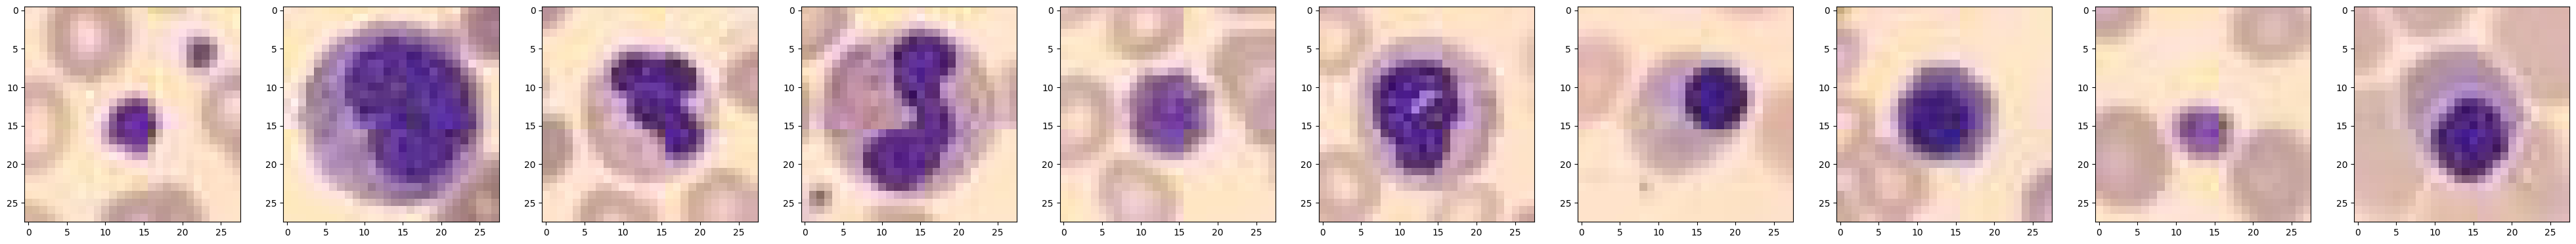

In [10]:
mean = torch.tensor([0.5], dtype=torch.float32)
std = torch.tensor([0.5], dtype=torch.float32)

# needs to be defined
plain_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(list(mean), list(std))])


# This is a helper function that you can use to visualize the images.
# Not necessary to use.
def imshow(img, i=0, mean=torch.tensor([0.0], dtype=torch.float32), std=torch.tensor([1], dtype=torch.float32)):
    """
    shows an image on the screen. mean of 0 and variance of 1 will show the images unchanged in the screen
    """
    # undoes the normalization
    unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    plt.subplot(1, 10 ,i+1)
    npimg = unnormalize(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# load the data
train_ds = DataClass(split='train', transform=plain_transform, download=download)
val_ds = DataClass(split='val', transform=plain_transform, download=download)
test_ds = DataClass(split='test', transform=plain_transform, download=download)

# create the data loaders
### START CODE HERE ### (approx. 3 lines)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=bs, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=bs, shuffle=True, num_workers=0)
### END CODE HERE ###

# check image shape and labels
img1, lab = next(iter(train_loader))
print(img1.shape)
print(lab.shape)


# How I used the imshow function to visualize samples:
plt.figure(figsize = (50,20))
for i in range(10):
    imshow(train_ds[i][0], i, mean, std)


## 1.3 Implement a small Conv Net

Define the following model:

- 2 Blocks of Conv-MaxPool-ReLU Layers
- 1 Block Conv-ReLU
- 1 Block of Linear-ReLU-Linear Layers

`base_channels` is a parameter that you should choose. It controls the width (number of parameters per layer) of the whole network.


The model will be initialized as follows:

```
model = Net(base_channels=2)  # 2 is for illustration purposes
```

A test function is provided so that you can check if you model can perform a forward pass.

Calculation of the input size of fc0:

conv1: $H_{out}, W_{out} = \frac{28 - 4 - 1}{1} + 1 = 24$

pool1: $H_{out}, W_{out} = \frac{24 - 1 - 1}{2} + 1= 12$

relu1: $H_{out}, W_{out} = 12$

conv2: $H_{out}, W_{out} =\frac{12 - 2 - 1}{1} + 1= 10 $

pool2:  $H_{out}, W_{out} = \frac{10 - 1 - 1}{2} + 1= 5$

relu2: $H_{out}, W_{out} = 2$

conv3: $H_{out}, W_{out} =\frac{5 - 2 - 1}{1} + 1= 3 $

In [11]:
from torch import nn

class Net(nn.Module):
    def __init__(self, base_channels=32, n_classes=8):
        super(Net, self).__init__()
        ### START CODE HERE ### (approx. 11 lines)
        # let's try the easiest way
        ## Cov-maxpool-relu 1
        self.conv1 = nn.Conv2d(3, base_channels, (5,5), stride = (1,1))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.relu1 = nn.ReLU(inplace = True)
        ## Cov-maxpool-relu 2
        self.conv2 = nn.Conv2d(base_channels, base_channels*2, (3,3), stride = (1,1))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride = 2)
        self.relu2 = nn.ReLU(inplace = True)
        ## Cov-relu 3
        self.conv3 = nn.Conv2d(base_channels*2, base_channels*4, (3,3), stride = (1,1))
        self.relu3 = nn.ReLU(inplace = True)
        ## linear-relu-linear
        self.fc0 = nn.Linear((base_channels*4)*3*3, out_features=64)
        self.act0 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64, out_features=n_classes)
        ### END CODE HERE ###


    def forward(self, x):
        ### START CODE HERE ### (approx. 6 lines)
        x3 = self.relu1(self.pool1(self.conv1(x)))
        x3 = self.relu2(self.pool2(self.conv2(x3)))
        x3 = self.relu3(self.conv3(x3))
        flat = nn.Flatten()
        x3 = self.fc0(flat(x3))
        x3 = self.act0(x3)
        x3 = self.fc1(x3)
        ### END CODE HERE ###
        return x3


def test_model_fw():
    model = Net(base_channels=4)
    x = torch.rand(1,3,28,28)
    out = model(x)
    print(out.shape)
    assert list(out.shape) == [1,8]
    print("Test passed")
    print(model)
test_model_fw()

torch.Size([1, 8])
Test passed
Net(
  (conv1): Conv2d(3, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU(inplace=True)
  (fc0): Linear(in_features=144, out_features=64, bias=True)
  (act0): ReLU(inplace=True)
  (fc1): Linear(in_features=64, out_features=8, bias=True)
)


## 1.4 Write the train/val code to train the model

 - Train the convnet model. Specify the hyperparameters and write the train/val code to train the model.
 - Save the model with the lowest validation loss for testing.
 - You need to keep track of the train accuracy, val accuracy and train loss and val loss for plotting the results of your training.


Some help to save and load your model:
```
torch.save({
            'epoch': EPOCH,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, path)


model = Net()
optimizer = optim.SGD(model.parameters(), lr=lr)

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
```

In the `validate` function you need to:

1. Move data and labels to the correct device
2. Get a model output
3. Compute a prediction based on the model output
4. Compute the number of correct predictions and accumulate it in the `correct` variable
5. Accumulate the total number of examples in the `total` variable
5. Get the Loss for the model output and save it
6. After the loop, compute the model's accuracy from `correct` and `total`
7. Return the accuracy and mean loss

In [12]:
def validate(model, val_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    correct, total = 0, 0
    loss_step = []
    bs = val_loader.batch_size
    with torch.no_grad():
        for inp_data, labels in val_loader:
            ### START CODE HERE ### (approx. 10 lines)
            # Move data and labels to the correct device
            inp_data, labels = inp_data.to(device), labels.to(device).squeeze()
            # Get a model output
            outp_data = model(inp_data)
            # Compute a prediction based on the model output
            predict = outp_data.argmax(dim=1)
            # Compute the number of correct predictions and accumulate it in the correct variable
            correct += sum(predict == labels)
            # Accumulate the total number of examples in the total variable
            total+=len(labels)
            # Get the Loss for the model output and save it
            val_loss = criterion(outp_data, labels).item()
            loss_step.append(val_loss)
        # After the loop, compute the model's accuracy from correct and total
        val_acc = (correct/total).item() * 100
        val_loss_epoch = (sum(loss_step)/len(val_loader))
        ### END CODE HERE ###
        return val_acc , val_loss_epoch

In the `train_one_epoch` function tou need to:

1. Move data and labels to the correct device
2. Get model outputs
3. Compute the loss
4. Zero the optimizer's gradients
5. Compute the backward pass
6. Update the model's parameters
7. Compute the model's accuracy, similar to the `validate` function, use `correct` and `total` for accumulation
8. After the epoch, compute the model's accuracy and mean loss for this epoch

In [13]:
def train_one_epoch(model, optimizer, train_loader, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    loss_step = []
    correct, total = 0, 0
    bs = train_loader.batch_size
    for (inp_data, labels) in train_loader:
        ### START CODE HERE ### (approx. 14 lines)
        # Move data and labels to the correct device
        inp_data, labels = inp_data.to(device), labels.to(device).squeeze()
        # Get a model output
        outp_data = model(inp_data)
        # Compute the loss
        train_loss = criterion(outp_data, labels)
        # Zero the optimizer's gradients
        optimizer.zero_grad()
        # Compute the backward pass
        train_loss.backward()
        # Update the model's parameters
        optimizer.step()
        loss_step.append(train_loss.item())
        # Compute a prediction based on the model output
        predict = outp_data.argmax(dim=1)
        # Compute the number of correct predictions and accumulate it in the correct variable
        correct += sum(predict == labels)
        total+=len(labels)
    # Compute the model's accuracy, similar to the validate function, use correct and total for accumulation
    train_acc = (correct/total).item()*100
    loss_curr_epoch = sum(loss_step)/len(loss_step)
    ### END CODE HERE ###
    return loss_curr_epoch, train_acc

The `train` function you need to:

1. Get the model's accuracy and mean loss for an epoch, using the `train_one_epoch` function
2. Get validation accuracy and loss, using the `validate` function

In [14]:
def train(model, optimizer, num_epochs, train_loader, val_loader, device):
    best_val_loss = 100
    best_val_acc = 0
    dict_log = {"train_acc_epoch":[], "val_acc_epoch":[], "loss_epoch":[], "val_loss":[]}
    train_acc, _ = validate(model, train_loader, device)
    val_acc, _ = validate(model, val_loader, device)
    print(f'Init Accuracy of the model: Train:{train_acc:.3f} \t Val:{val_acc:3f}')
    for epoch in range(num_epochs):
        ### START CODE HERE ### (approx. 2 lines)
        loss_curr_epoch, train_acc = train_one_epoch(model, optimizer, train_loader, device)
        val_acc,val_loss = validate(model, val_loader, device)
        ### END CODE HERE ###

        # Print epoch results to screen
        print(f'Ep {epoch}/{num_epochs}: Accuracy : Train:{train_acc:.2f} \t Val:{val_acc:.2f} || Loss: Train {loss_curr_epoch:.3f} \t Val {val_loss:.3f}')
        # Track stats
        dict_log["train_acc_epoch"].append(train_acc)
        dict_log["val_acc_epoch"].append(val_acc)
        dict_log["loss_epoch"].append(loss_curr_epoch)
        dict_log["val_loss"].append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': val_loss,
                  }, f'best_model_min_val_loss.pth')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                  'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': val_loss,
                  }, f'best_model_max_val_acc.pth')
    return dict_log

## 1.5 Choose a set of hyperparameters and train the convnet

Choose a learning rate, weight decay, number of epochs and number of base channels. Initialize your network and run the training.

In [15]:
device = "cuda"

### START CODE HERE ### (approx. 5 lines)
num_epochs = 100
learning_rate = 0.01
wd = 0.001
model = Net().to(device)
### END CODE HERE ###

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wd)
dict_log = train(model, optimizer, num_epochs, train_loader, val_loader, device)

Init Accuracy of the model: Train:19.659 	 Val:20.268691
Ep 0/100: Accuracy : Train:19.42 	 Val:19.51 || Loss: Train 2.061 	 Val 2.053
Ep 1/100: Accuracy : Train:19.42 	 Val:19.45 || Loss: Train 2.046 	 Val 2.038
Ep 2/100: Accuracy : Train:19.45 	 Val:19.45 || Loss: Train 2.034 	 Val 2.027
Ep 3/100: Accuracy : Train:19.48 	 Val:19.45 || Loss: Train 2.025 	 Val 2.022
Ep 4/100: Accuracy : Train:19.48 	 Val:19.45 || Loss: Train 2.017 	 Val 2.015
Ep 5/100: Accuracy : Train:19.48 	 Val:19.45 || Loss: Train 2.008 	 Val 2.001
Ep 6/100: Accuracy : Train:19.57 	 Val:19.33 || Loss: Train 1.997 	 Val 1.987
Ep 7/100: Accuracy : Train:21.31 	 Val:32.18 || Loss: Train 1.974 	 Val 1.947
Ep 8/100: Accuracy : Train:37.36 	 Val:42.58 || Loss: Train 1.869 	 Val 1.734
Ep 9/100: Accuracy : Train:45.07 	 Val:46.73 || Loss: Train 1.584 	 Val 1.446
Ep 10/100: Accuracy : Train:50.26 	 Val:51.29 || Loss: Train 1.325 	 Val 1.274
Ep 11/100: Accuracy : Train:53.46 	 Val:51.69 || Loss: Train 1.219 	 Val 1.230
Ep 12

#### Expected results
```
Ep 0/100: Accuracy : Train:16.95 	 Val:17.01 || Loss: Train 2.070 	 Val 2.056
...................................
Ep 20/100: Accuracy : Train:75.65 	 Val:75.30 || Loss: Train 0.702 	 Val 0.647
...................................
Ep 74/100: Accuracy : Train:89.46 	 Val:88.40 || Loss: Train 0.313 	 Val 0.317
...................................
Ep 96/100: Accuracy : Train:91.65 	 Val:89.66 || Loss: Train 0.257 	 Val 0.272
```


## 1.6 Load your best model and test it on the test set

The code below load the checkpoint for the best models, based on validation loss and accuracy and finds the test loss and test accuracy.

Is it close to the train and val set?

You should get around 90% val accuracy here

In [16]:
path = "best_model_min_val_loss.pth"
path2 = "best_model_max_val_acc.pth"
def load_model(model, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model {path} is loaded from epoch {checkpoint['epoch']} , loss {checkpoint['loss']}")
    return model

def test_model(model, path, test_loader, device='cuda'):
    model = load_model(model, path)
    model.to("cuda")
    model.eval()
    return validate(model, test_loader, device)

### START CODE HERE ### (approx. 3 lines)
print(list(test_model(model, path, test_loader)))
print(list(test_model(model, path2, test_loader)))
 ### END CODE HERE ###

Model best_model_min_val_loss.pth is loaded from epoch 96 , loss 0.4550085536071232
[82.54895806312561, 0.4791118789602209]
Model best_model_max_val_acc.pth is loaded from epoch 84 , loss 0.4679854320628302
[81.993567943573, 0.49421081719575105]


## 1.7 Plot train/val accuracies and train/val loss

Complete the `plot_stats` function below.

In [17]:
dict_log.keys()

dict_keys(['train_acc_epoch', 'val_acc_epoch', 'loss_epoch', 'val_loss'])

In [18]:
import os
os.mkdir("figs")

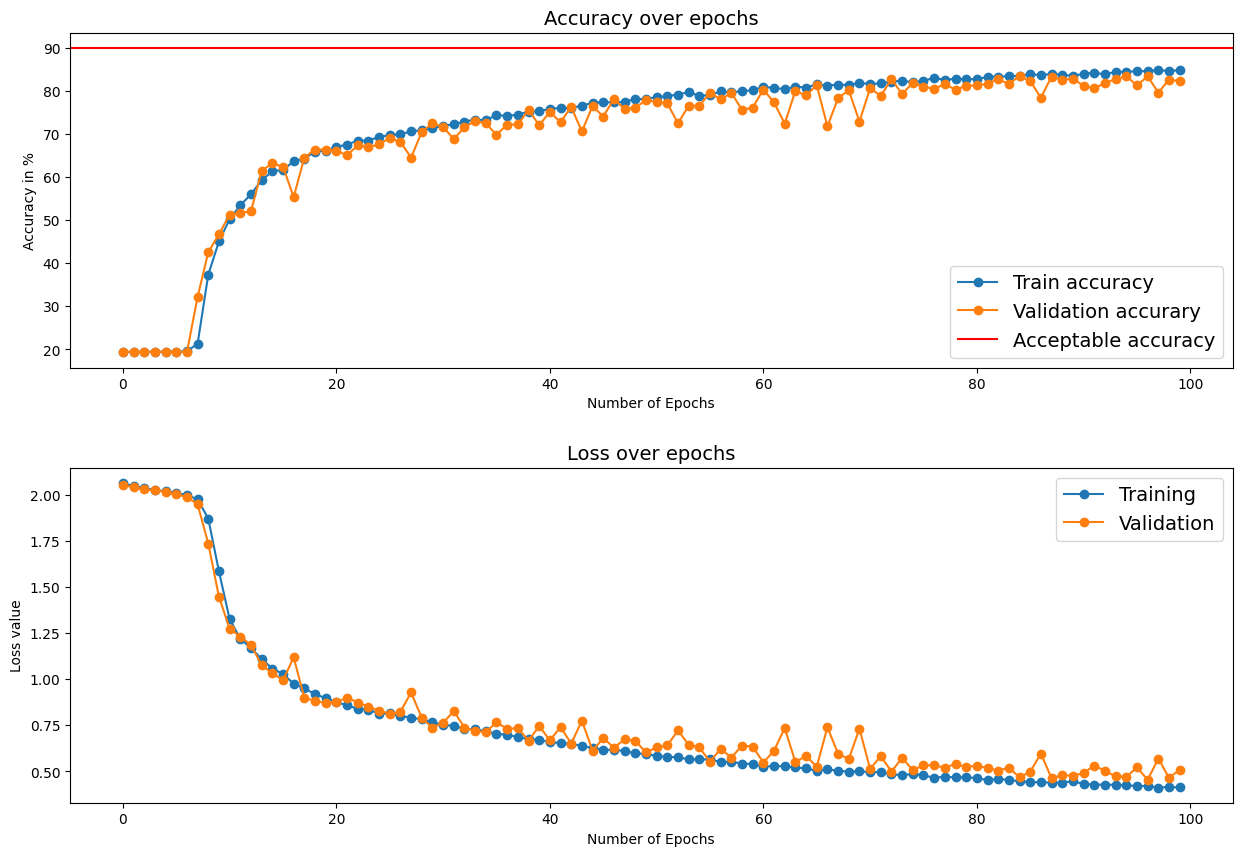

In [19]:
import matplotlib.pyplot as plt


def plot_stats(dict_log, baseline=90, title=None):
    fontsize = 14
    figsize = (15,10)
    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0.3)
    plt.subplot(2,1,1)
    ### START CODE HERE ### (approx. 5 lines)
    plt.plot(dict_log["train_acc_epoch"] , label="Train accuracy", marker = "o")
    plt.plot(dict_log["val_acc_epoch"] , label="Validation accurary",  marker = "o")
    ### END CODE HERE ###


    plt.ylabel('Accuracy in %')
    plt.xlabel('Number of Epochs')
    plt.title("Accuracy over epochs", fontsize=fontsize)
    plt.axhline(y=baseline, color='red', label="Acceptable accuracy")
    plt.legend(fontsize=fontsize)


    plt.subplot(2,1,2)
    plt.plot(dict_log["loss_epoch"] , label="Training", marker = "o")
    ### START CODE HERE ### (approx. 3 lines)
    plt.plot(dict_log["val_loss"] , label="Validation", marker = "o")
    ### END CODE HERE ###

    plt.ylabel('Loss value')
    plt.xlabel('Number of Epochs')
    plt.title("Loss over epochs", fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    if title is not None:
        plt.savefig(title)

plot_stats(dict_log, baseline=90, title='figs/exp_1_bloddmnist.png')


![exp_1_bloddmnist.png](https://raw.githubusercontent.com/HHU-MMBS/Deep-Learning-Exercise-Extras/main/a07-08_mednist/figs/exp_1_bloddmnist.png)

## 1.8 Use sklearn.metrics to get insights on per class predictions
```
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
```
You will need to iterate through the test data with the trained model and generate `y_true` and `y_pred` lists ( labels and predictions respectivly)


### Questions to think about:

Analyze and try to understand the outputs:

- Which class is the harder to predict?

- Are the predictions equally good for all classes? Which class(es) is misclassified more frequently?

- Is accuracy always a good metric? And if not why are the other metrics better to infer the behaviour of the model?



Model best_model_min_val_loss.pth is loaded from epoch 96 , loss 0.4550085536071232
82.54895806312561 0.4809472284935139
              precision    recall  f1-score   support

           0      0.681     0.402     0.505       244
           1      0.938     0.877     0.906       624
           2      0.878     0.814     0.845       311
           3      0.622     0.784     0.694       579
           4      0.829     0.840     0.834       243
           5      0.633     0.630     0.631       284
           6      0.926     0.934     0.930       666
           7      0.983     0.994     0.988       470

    accuracy                          0.825      3421
   macro avg      0.811     0.784     0.792      3421
weighted avg      0.831     0.825     0.824      3421



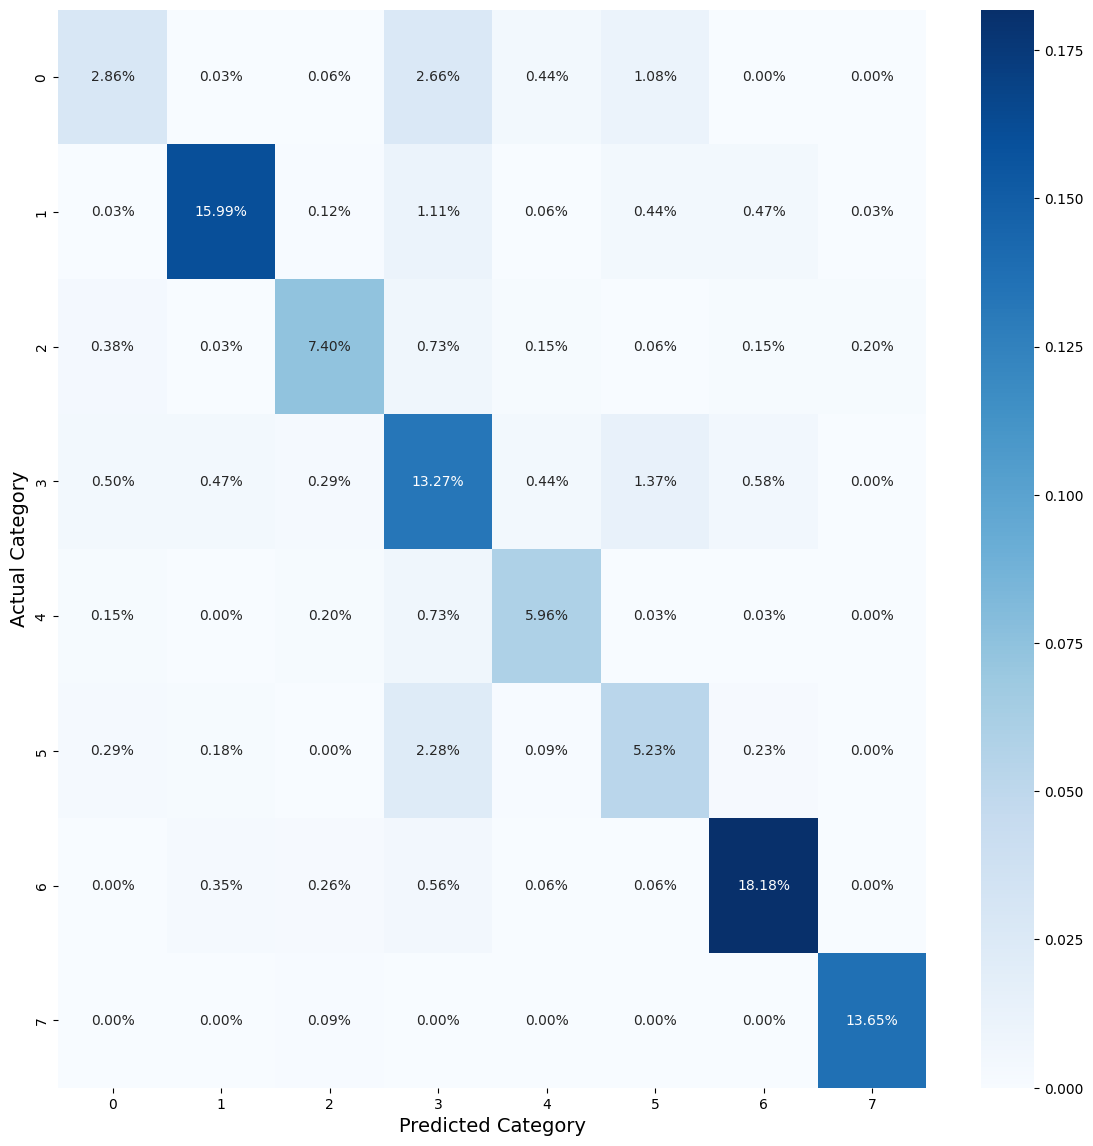

In [20]:
import os
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
fontsize = 14
figsize=(14,14)

# Load the best model
### START CODE HERE ### (approx. 2 lines)
model = load_model(model, path)
### END CODE HERE ###

device = 'cuda'
model = model.to(device)
model.eval()

# get test accuracy
test_acc, test_loss = validate(model, test_loader, device)
print(test_acc, test_loss)
y_pred = []
y_true = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(
    y_true, y_pred,  digits=3))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

fig = plt.figure(figsize=figsize)
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.ylabel('Actual Category', fontsize=fontsize)
plt.xlabel('Predicted Category', fontsize=fontsize)

plt.savefig("figs/exp_1_conf_mat.png")
plt.show()

![exp_1_conf.png](https://raw.githubusercontent.com/HHU-MMBS/Deep-Learning-Exercise-Extras/main/a07-08_mednist/figs/exp_1_conf_mat.png)

# 2. Training tricks and scaling up our model and data

Well, we have trained our small convnet that scores around 90% test accuracy on bloodmnist (17,092 images).

Some questions still arise:
- Is our convet good enough?
- How can we further increase our performance?
- Does it work well enoough with larger amounts of data?
- What is the critical component of larger scale convnets like Resnets?

To this end, in the 2nd part we will:

- First we will first add some image augmentations to our training data.
- Then we will see the impact of [Batch normalization](https://arxiv.org/abs/1502.03167) to our small convnet, which is a core component of large scale convnet like resnet and observe the training dynamics.
- Afterwards, we will scale-up our model from the small convnet to the famous resnet-18.




**End Goal**: We would like to have a validation accuracy over 94% for bloodmnist.

## 2.1 Define the data augmentation pipelines

Training data augmentations you should implement:
- Horizontal flip with 50% probability
- Vertical flip with 50% probability
- Random crop images to 80-100 % of the initial size
- Resize images to 28x28
- intensity jitter: 20% brightness and 20% contrast with 80% probability
- Mean/std norm with mean=0.5 and std=0.5 for all channels

At val/test time, only mean/std normalization will be applied.

Hint: use [torchvision](https://pytorch.org/vision/stable/transforms.html) for creating the data augmentation pipeline.

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
<class 'medmnist.dataset.BloodMNIST'>


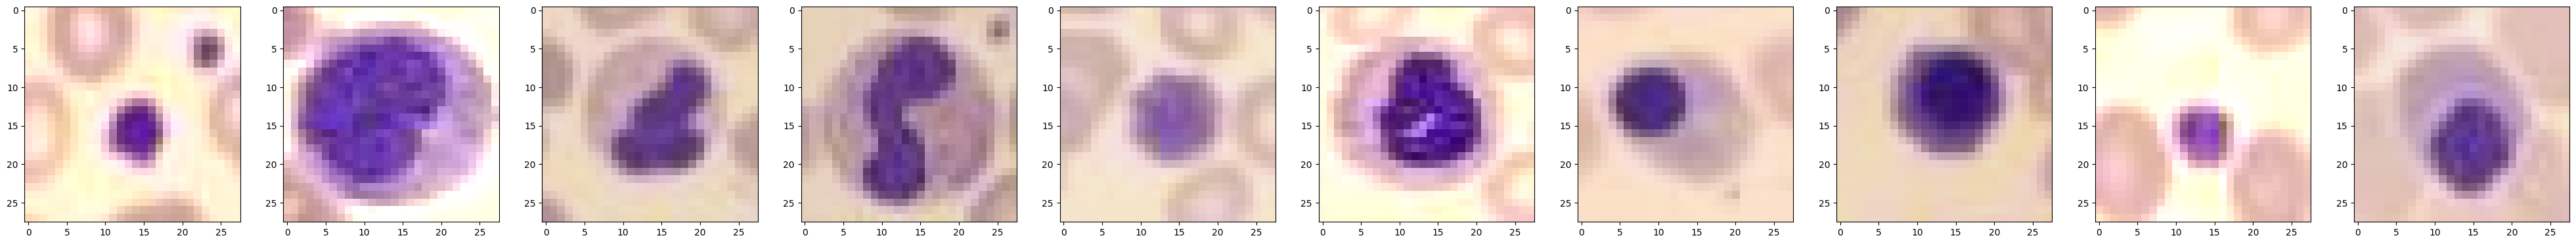

In [21]:
mean = torch.tensor([0.5], dtype=torch.float32)
std = torch.tensor([0.5], dtype=torch.float32)
batch_size = 128

### START CODE HERE ### (approx. 8 lines)
from torchvision.transforms import v2
train_transform_augs = T.Compose([
    T.ToTensor(),
    # Horizontal flip with 50% probability
    T.RandomHorizontalFlip(p=0.5),
    # Vertical flip with 50% probability
    T.RandomVerticalFlip(p=0.5),
    # Random crop images to 80-100 % of the initial size
    # Resize images to 28x28,
    T.RandomResizedCrop(size=(28, 28), scale = (0.8, 1.0), antialias=False),
    # Intensity jitter: 20% brightness and 20% contrast with 80% probability
    T.ColorJitter(brightness = 0.2, contrast = 0.2),
    # Mean/std norm with mean=0.5 and std=0.5 for all channels
    T.Normalize(list(mean), list(std))
])
### END CODE HERE ###

plain_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(list(mean), list(std))])

# This is a helper function that you can use to visualize the images.
# Not necessary to use.
def imshow(img, i=0, mean=torch.tensor([0.0], dtype=torch.float32), std=torch.tensor([1], dtype=torch.float32)):
    """
    shows an image on the screen. mean of 0 and variance of 1 will show the images unchanged in the screen
    """
    # undoes the normalization
    unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    plt.subplot(1, 10 ,i+1)
    npimg = unnormalize(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# load the data
train_ds = DataClass(split='train', transform=train_transform_augs, download=download)
train_plain = DataClass(split='train', transform=plain_transform, download=download)
val_ds = DataClass(split='val', transform=plain_transform, download=download)
test_ds = DataClass(split='test', transform=plain_transform, download=download)
print(type(train_ds))

train_loader = data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader_plain = data.DataLoader(dataset=train_plain, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = data.DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False, drop_last=True)

img1, lab = next(iter(train_loader))

# How I used the imshow function to visualize samples:
plt.figure(figsize = (50,20))
for i in range(10):
    imshow(train_ds[i][0], i, mean, std)

## 2.2 Add batch normalization to our convnet

Take the convnet from our previous exercise and add 3 batch normalization layers after the convolutions or activation functions (you should decide where).

Questions that may help:

- Should you use `BatchNorm1d`, `BatchNorm2d`, or `BatchNorm3d`? What are the arguments that you should specify? Check the documentation.
- In which order should you apply the normalization , i.e. before or after the activation function?
- What training behaviour do you expect? Guess or check the published paper.

The network WITHOUT batch norm should look like this:


```
 Net(
  (conv1): Conv2d(in_channels, base_channels, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(in_channels, base_channels*2 , kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(in_channels, base_channels*4, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU(inplace=True)

    (fc0): Linear(in_channels, out_features=64)
    (act0): ReLU(inplace=True)
    (fc2): Linear(in_channels, n_classes)
  )
)
```

The model can be initialized as follows:

```
model = Net(base_channels=2, n_classes=2, batch_norm=True) # batch_norm is Optional to implement.
```
Use the same number of base channels as in the previous model without batchnorm so that you can see the differences while training.

- `batch_norm` is a boolean argument. It is optional to implement it this way. The idea is to specify whether we want to add batch norm in the architecture or not.

In [26]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, base_channels=2, n_classes=2, batch_norm=False):
        super(Net, self).__init__()
        ### START CODE HERE ### (approx. 15 lines)
        layers = []
        ## Cov-maxpool-relu 1
        layers.append(nn.Conv2d(3, base_channels, (5,5), stride = (1,1)))
        layers.append(nn.MaxPool2d(kernel_size=2, stride = 2))
        if batch_norm == True: layers.append(nn.BatchNorm2d(base_channels))
        layers.append(nn.ReLU(inplace = True))
        ## Cov-maxpool-relu 2
        layers.append(nn.Conv2d(base_channels, base_channels*2, (3,3), stride = (1,1)))
        layers.append(nn.MaxPool2d(kernel_size=2, stride = 2))
        if batch_norm == True: layers.append(nn.BatchNorm2d(base_channels*2))
        layers.append(nn.ReLU(inplace = True))
        ## Cov-relu 3
        layers.append(nn.Conv2d(base_channels*2, base_channels*4, (3,3), stride = (1,1)))
        if batch_norm == True: layers.append(nn.BatchNorm2d(base_channels*4))
        layers.append(nn.ReLU(inplace = True))
        self.layers = nn.Sequential(*layers)
        ## linear-relu-linear
        self.fc0 = nn.Linear((base_channels*4)*3*3, out_features=64)
        self.act0 = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(64, out_features=n_classes)
        ### END CODE HERE ###

    def forward(self, x):
        bs = x.shape[0]
        ### START CODE HERE ### (approx. 6 lines)
        x3 = x
        for layer in self.layers:
          x3 = layer(x3)
        flat = nn.Flatten()
        x3 = self.fc0(flat(x3))
        x3 = self.act0(x3)
        x3 = self.fc1(x3)
        ### END CODE HERE ###
        return x3

def test():
    c = 15
    model = Net(base_channels=4,n_classes=c, batch_norm=True)
    x = torch.rand(1,3,28,28)
    out = model(x)
    assert list(out.shape) == [1,c]
    model = Net(base_channels=4,n_classes=c, batch_norm=False)
    assert list(model(x).shape) == [1,c]
    print("Test passed")
test()

Test passed


## 2.3 Train the convnet with batch normalization

Use the already implemented functions from part 1 to train the model with the new data and batch norm.

Anything above 50 epochs should be enough. Use the same hyperparameter setup that you found in the previous part.

In [28]:
device = 'cuda'
num_epochs = 80

print("Training with Batch Normalization and image augmentations")
### START CODE HERE ### (approx. 4 lines)
model = Net(base_channels=32, n_classes=n_classes, batch_norm=True).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=wd)
dict_log = train(model, optimizer, num_epochs, train_loader, val_loader, device)
### END CODE HERE ###


Training with Batch Normalization and image augmentations
Init Accuracy of the model: Train:16.910 	 Val:17.007212
Ep 0/80: Accuracy : Train:58.14 	 Val:74.58 || Loss: Train 1.470 	 Val 0.885
Ep 1/80: Accuracy : Train:73.37 	 Val:76.56 || Loss: Train 0.836 	 Val 0.649
Ep 2/80: Accuracy : Train:75.83 	 Val:77.76 || Loss: Train 0.680 	 Val 0.605
Ep 3/80: Accuracy : Train:77.66 	 Val:79.33 || Loss: Train 0.611 	 Val 0.519
Ep 4/80: Accuracy : Train:79.38 	 Val:81.79 || Loss: Train 0.559 	 Val 0.488
Ep 5/80: Accuracy : Train:80.60 	 Val:82.57 || Loss: Train 0.525 	 Val 0.457
Ep 6/80: Accuracy : Train:81.91 	 Val:82.45 || Loss: Train 0.498 	 Val 0.445
Ep 7/80: Accuracy : Train:82.90 	 Val:85.34 || Loss: Train 0.465 	 Val 0.414
Ep 8/80: Accuracy : Train:83.84 	 Val:85.28 || Loss: Train 0.446 	 Val 0.408
Ep 9/80: Accuracy : Train:84.76 	 Val:86.48 || Loss: Train 0.424 	 Val 0.377
Ep 10/80: Accuracy : Train:85.89 	 Val:87.62 || Loss: Train 0.397 	 Val 0.357
Ep 11/80: Accuracy : Train:86.45 	 Va

**Expected results:**

```
Ep 0/80: Accuracy : Train:56.88 	 Val:73.62 || Loss: Train 1.403 	 Val 0.872
Ep 1/80: Accuracy : Train:73.20 	 Val:76.74 || Loss: Train 0.812 	 Val 0.665
Ep 2/80: Accuracy : Train:76.00 	 Val:79.21 || Loss: Train 0.675 	 Val 0.575
Ep 3/80: Accuracy : Train:78.16 	 Val:80.29 || Loss: Train 0.602 	 Val 0.528
Ep 4/80: Accuracy : Train:80.00 	 Val:80.41 || Loss: Train 0.554 	 Val 0.512
Ep 5/80: Accuracy : Train:81.17 	 Val:83.59 || Loss: Train 0.519 	 Val 0.459
Ep 6/80: Accuracy : Train:82.01 	 Val:83.47 || Loss: Train 0.496 	 Val 0.443
Ep 7/80: Accuracy : Train:83.48 	 Val:85.28 || Loss: Train 0.467 	 Val 0.414
Ep 8/80: Accuracy : Train:84.24 	 Val:86.36 || Loss: Train 0.442 	 Val 0.389
Ep 9/80: Accuracy : Train:84.81 	 Val:85.88 || Loss: Train 0.419 	 Val 0.385
Ep 10/80: Accuracy : Train:85.66 	 Val:88.46 || Loss: Train 0.398 	 Val 0.336
Ep 11/80: Accuracy : Train:86.48 	 Val:87.38 || Loss: Train 0.387 	 Val 0.356
Ep 12/80: Accuracy : Train:87.00 	 Val:88.22 || Loss: Train 0.369 	 Val 0.339
Ep 13/80: Accuracy : Train:87.05 	 Val:89.06 || Loss: Train 0.359 	 Val 0.313
Ep 14/80: Accuracy : Train:87.42 	 Val:88.10 || Loss: Train 0.345 	 Val 0.310
Ep 15/80: Accuracy : Train:87.89 	 Val:90.81 || Loss: Train 0.337 	 Val 0.273
Ep 16/80: Accuracy : Train:88.71 	 Val:90.44 || Loss: Train 0.324 	 Val 0.275
Ep 17/80: Accuracy : Train:88.63 	 Val:88.64 || Loss: Train 0.311 	 Val 0.325
Ep 18/80: Accuracy : Train:89.21 	 Val:91.29 || Loss: Train 0.306 	 Val 0.259
Ep 19/80: Accuracy : Train:89.04 	 Val:91.71 || Loss: Train 0.301 	 Val 0.247
Ep 20/80: Accuracy : Train:89.50 	 Val:90.56 || Loss: Train 0.291 	 Val 0.259
Ep 21/80: Accuracy : Train:89.75 	 Val:90.56 || Loss: Train 0.286 	 Val 0.254
Ep 22/80: Accuracy : Train:90.05 	 Val:87.20 || Loss: Train 0.279 	 Val 0.324
...
Ep 30/80: Accuracy : Train:91.23 	 Val:92.37 || Loss: Train 0.242 	 Val 0.206
Ep 31/80: Accuracy : Train:91.43 	 Val:92.79 || Loss: Train 0.239 	 Val 0.202
Ep 32/80: Accuracy : Train:91.58 	 Val:91.59 || Loss: Train 0.233 	 Val 0.220
Ep 33/80: Accuracy : Train:91.89 	 Val:90.38 || Loss: Train 0.232 	 Val 0.266
```



## 2.4 Test the model and plot the training stats.

Use the same function from part 1 to:
- Plot the training stats.
- Test the model on the test data and print the test accuracy.

Model best_model_min_val_loss.pth is loaded from epoch 73 , loss 0.14916443538207275
Test Accuracy : 94.56 	 || Loss 0.165
Model best_model_max_val_acc.pth is loaded from epoch 75 , loss 0.14957021921873093
Test Accuracy : 94.86 	 || Loss 0.155


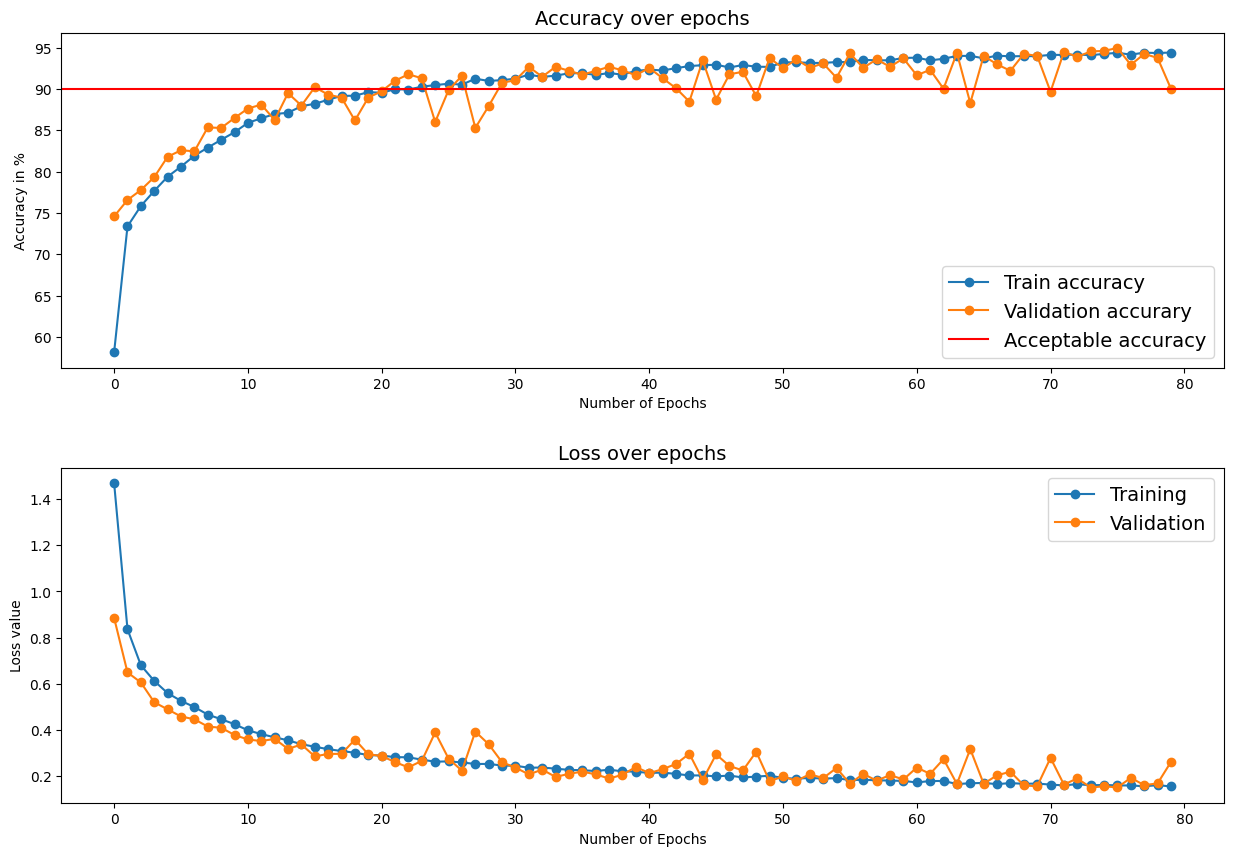

In [31]:
### START CODE HERE ### (approx. 5 lines)
plot_stats(dict_log, baseline=90, title='figs/exp_2_batch_bloddmnist.png')
for i in [path, path2]:
  test_acc, test_loss = test_model(model, i, test_loader)
  print(f'Test Accuracy : {test_acc:.2f} \t || Loss {test_loss:.3f}')
### END CODE HERE ###

**Expected Results:**

![exp_2.png](https://raw.githubusercontent.com/HHU-MMBS/Deep-Learning-Exercise-Extras/main/a07-08_mednist/figs/exp_2_bloddmnist.png)



## 2.5 Load, mofidy and train the resnet18

Now we will use `torchvision.models`.

- Load Resnet 18 from torchvision. How many trainble parameters does the network have?
- Important: Do **not** use pretrained weights. We will train the model from scratch.

Print the model.
A. How should you modify the last linear layer?
B. How is the first layer look like? If you were to modify the input conv layer how would you modify it for `bloddmnist` (3-channeled 28x28 images) ?
Think about the size of the input image and the first conv layer. Is it a good choice? If not, what would you replace it with? Hint: resnets are designed for higher resolution images, i.e. 224x224.


Train for at least 40 epochs and save the model with the best val score Compare the results with our small convnet.

Expected results: 94-95 % validation set accuracy.
No augmentations should been applied in the validation set. In this way, we can make an estimation of the test set performance (given the i.i.d. assumption).



In [51]:
import torchvision

def get_resnet18(in_channels, n_classes):
    ### START CODE HERE ### (approx. 3 lines)
    model = torchvision.models.resnet18()
    model.conv1.in_channels=in_channels
    model.fc.out_features=n_classes
    ### END CODE HERE ###
    return model

model_3 = get_resnet18(3, 8)


In [53]:
model_3 = model_3.to(device)

## 2.6 Train the resnet18

- Train the resnet for at least 40 epochs (we trained for 80 epochs)
- Plot train stats
- Compute test accuracy

In [54]:
num_epochs = 60
path = "best_model_min_val_loss.pth"
### START CODE HERE ### (approx. 6 lines)
optimizer = torch.optim.SGD(model_3.parameters(), lr=learning_rate, weight_decay=wd)
dict_log = train(model_3, optimizer, num_epochs, train_loader, val_loader, device)
### END CODE HERE ###


Init Accuracy of the model: Train:0.000 	 Val:0.000000
Ep 0/60: Accuracy : Train:63.72 	 Val:76.50 || Loss: Train 1.363 	 Val 0.628
Ep 1/60: Accuracy : Train:76.61 	 Val:82.03 || Loss: Train 0.639 	 Val 0.495
Ep 2/60: Accuracy : Train:80.11 	 Val:79.03 || Loss: Train 0.540 	 Val 0.585
Ep 3/60: Accuracy : Train:81.49 	 Val:82.51 || Loss: Train 0.497 	 Val 0.496
Ep 4/60: Accuracy : Train:83.25 	 Val:83.11 || Loss: Train 0.456 	 Val 0.459
Ep 5/60: Accuracy : Train:84.18 	 Val:84.80 || Loss: Train 0.424 	 Val 0.414
Ep 6/60: Accuracy : Train:85.34 	 Val:89.36 || Loss: Train 0.399 	 Val 0.314
Ep 7/60: Accuracy : Train:86.18 	 Val:85.88 || Loss: Train 0.375 	 Val 0.423
Ep 8/60: Accuracy : Train:86.15 	 Val:89.06 || Loss: Train 0.373 	 Val 0.327
Ep 9/60: Accuracy : Train:87.29 	 Val:86.48 || Loss: Train 0.347 	 Val 0.364
Ep 10/60: Accuracy : Train:88.09 	 Val:90.26 || Loss: Train 0.325 	 Val 0.286
Ep 11/60: Accuracy : Train:88.05 	 Val:87.92 || Loss: Train 0.317 	 Val 0.337
Ep 12/60: Accuracy 

In [55]:
for i in [path, path2]:
  test_acc, test_loss = test_model(model_3, i, test_loader)
  print(f'Test Accuracy : {test_acc:.2f} \t || Loss {test_loss:.3f}')

Model best_model_min_val_loss.pth is loaded from epoch 48 , loss 0.15107432122413927
Test Accuracy : 93.42 	 || Loss 0.198
Model best_model_max_val_acc.pth is loaded from epoch 52 , loss 0.15887029812886164
Test Accuracy : 93.30 	 || Loss 0.198


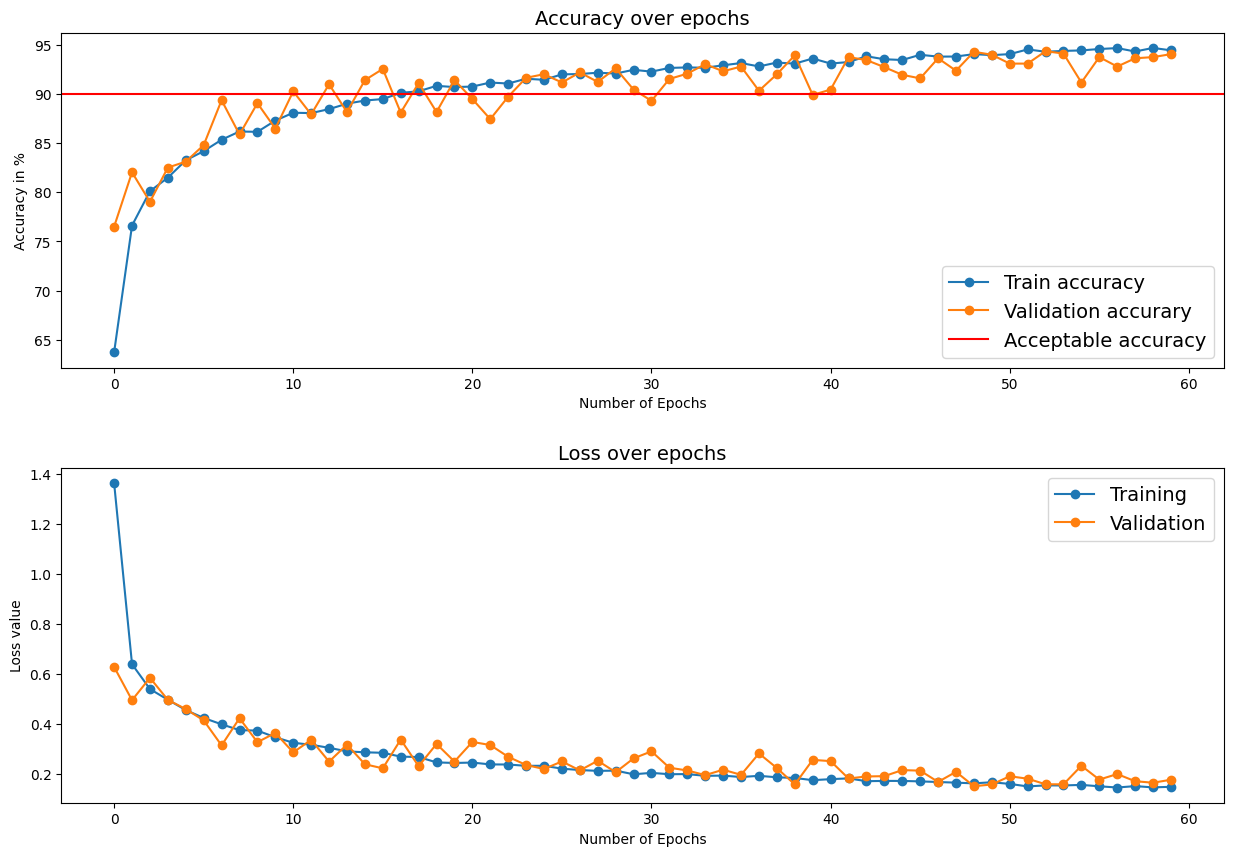

In [57]:
plot_stats(dict_log, baseline=90, title='figs/exp_3_resnet_bloddmnist.png')

### Expected results
```
Ep 1/80: Accuracy : Train:78.91 	 Val:82.63 || Loss: Train 0.643 	 Val 0.484
.........
Ep 13/80: Accuracy : Train:90.65 	 Val:92.55 || Loss: Train 0.276 	 Val 0.212
.........
Ep 32/80: Accuracy : Train:94.26 	 Val:94.47 || Loss: Train 0.176 	 Val 0.154
.........
Ep 42/80: Accuracy : Train:94.99 	 Val:94.95 || Loss: Train 0.152 	 Val 0.139
.........
Ep 60/80: Accuracy : Train:95.98 	 Val:95.31 || Loss: Train 0.126 	 Val 0.132
.........

```


![exp_3.png](https://raw.githubusercontent.com/HHU-MMBS/Deep-Learning-Exercise-Extras/main/a07-08_mednist/figs/exp_3_bloddmnist_resnet.png)

# 3. Scaling up to a larger dataset: pathmnist

In this last part, we will scale up our dataset. We will use 'pathmnist' that has  `107,180 images`.

**End Goal**: We would like to have a validation accuracy over 90% on pathmnist.

## 3.1 Load the new dataset and create the dataloaders
We will use the same augmentations from part 2. Use a batch size of 256.

n_classes 9


100%|██████████| 205615438/205615438 [00:10<00:00, 20137358.57it/s]


Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


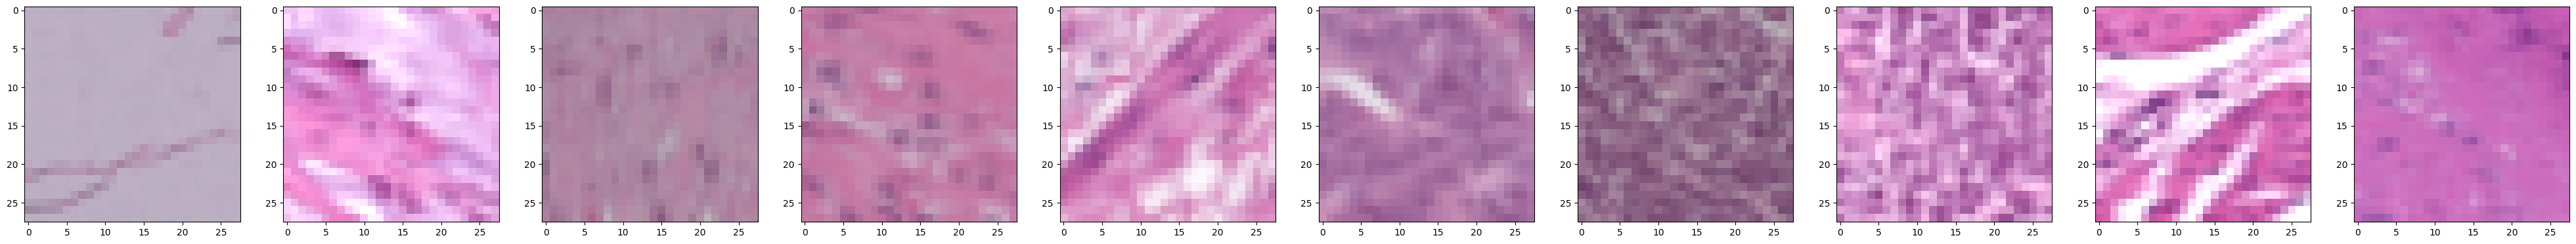

In [58]:
# Specify dataset
data_flag = 'pathmnist'
download = True
batch_size = 256
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
print("n_classes",n_classes)
DataClass = getattr(medmnist, info['python_class'])

mean = torch.tensor([0.5], dtype=torch.float32)
std = torch.tensor([0.5], dtype=torch.float32)


# Note: train_transform_augs needs to be already defined from part 2

plain_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(list(mean), list(std))])

# load the data
train_ds = DataClass(split='train', transform=train_transform_augs, download=download)
train_plain = DataClass(split='train', transform=plain_transform, download=download)
val_ds = DataClass(split='val', transform=plain_transform, download=download)
test_ds = DataClass(split='test', transform=plain_transform, download=download)

train_loader = data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
train_loader_plain = data.DataLoader(dataset=train_plain, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = data.DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = data.DataLoader(dataset=test_ds, batch_size=batch_size, shuffle=False, drop_last=True)

plt.figure(figsize = (50,20))
for i in range(10):
    imshow(train_ds[i][0], i, mean, std)

## 3.2 Train resnet18 on the pathmnist data

The small convnet with batch-normalization we built in part 2 scores around 87% validation accuracy on pathmnist.

We would like to have at least 90% though.

You task is to surpass the performance of the convnet with resnet18. Train for at least 15 epochs (we trained for 30).

In [60]:
num_epochs = 16

device = "cuda"
# get the model and optimizer and launch training
### START CODE HERE ### (approx. 4 lines)
model_3 = get_resnet18(n_channels, n_classes).to(device)
optimizer = torch.optim.SGD(model_3.parameters(), lr=learning_rate, weight_decay=wd)
dict_log = train(model_3, optimizer, num_epochs, train_loader, val_loader, device)
### END CODE HERE ###


Init Accuracy of the model: Train:0.000 	 Val:0.000000
Ep 0/16: Accuracy : Train:55.77 	 Val:53.77 || Loss: Train 1.314 	 Val 1.288
Ep 1/16: Accuracy : Train:66.85 	 Val:62.75 || Loss: Train 0.901 	 Val 1.021
Ep 2/16: Accuracy : Train:71.16 	 Val:56.63 || Loss: Train 0.778 	 Val 1.248
Ep 3/16: Accuracy : Train:74.04 	 Val:72.09 || Loss: Train 0.704 	 Val 0.845
Ep 4/16: Accuracy : Train:75.82 	 Val:43.17 || Loss: Train 0.654 	 Val 2.139
Ep 5/16: Accuracy : Train:77.58 	 Val:70.25 || Loss: Train 0.610 	 Val 0.865
Ep 6/16: Accuracy : Train:79.31 	 Val:72.79 || Loss: Train 0.567 	 Val 0.764
Ep 7/16: Accuracy : Train:80.48 	 Val:79.48 || Loss: Train 0.534 	 Val 0.571
Ep 8/16: Accuracy : Train:81.33 	 Val:67.37 || Loss: Train 0.506 	 Val 0.939
Ep 9/16: Accuracy : Train:82.25 	 Val:73.04 || Loss: Train 0.483 	 Val 0.750
Ep 10/16: Accuracy : Train:83.03 	 Val:70.73 || Loss: Train 0.460 	 Val 0.863
Ep 11/16: Accuracy : Train:83.74 	 Val:79.91 || Loss: Train 0.442 	 Val 0.558
Ep 12/16: Accuracy 

### Expected results

```
Ep 0/30: Accuracy : Train:54.65 	 Val:59.77 || Loss: Train 1.250 	 Val 1.109
Ep 1/30: Accuracy : Train:68.83 	 Val:67.56 || Loss: Train 0.846 	 Val 0.856
Ep 2/30: Accuracy : Train:74.67 	 Val:77.20 || Loss: Train 0.683 	 Val 0.626
Ep 3/30: Accuracy : Train:78.21 	 Val:77.19 || Loss: Train 0.592 	 Val 0.616
Ep 4/30: Accuracy : Train:80.79 	 Val:75.09 || Loss: Train 0.523 	 Val 0.701
Ep 5/30: Accuracy : Train:82.82 	 Val:77.75 || Loss: Train 0.473 	 Val 0.612
Ep 6/30: Accuracy : Train:84.26 	 Val:75.41 || Loss: Train 0.432 	 Val 0.812
Ep 7/30: Accuracy : Train:85.42 	 Val:82.15 || Loss: Train 0.403 	 Val 0.493
Ep 8/30: Accuracy : Train:86.25 	 Val:85.77 || Loss: Train 0.380 	 Val 0.376
Ep 9/30: Accuracy : Train:86.97 	 Val:84.85 || Loss: Train 0.359 	 Val 0.434
Ep 10/30: Accuracy : Train:87.64 	 Val:87.33 || Loss: Train 0.344 	 Val 0.348
Ep 11/30: Accuracy : Train:88.25 	 Val:82.01 || Loss: Train 0.327 	 Val 0.498
Ep 12/30: Accuracy : Train:88.48 	 Val:85.16 || Loss: Train 0.318 	 Val 0.402
Ep 13/30: Accuracy : Train:89.02 	 Val:64.41 || Loss: Train 0.302 	 Val 1.363
Ep 14/30: Accuracy : Train:89.69 	 Val:87.13 || Loss: Train 0.288 	 Val 0.355
Ep 15/30: Accuracy : Train:89.99 	 Val:76.81 || Loss: Train 0.278 	 Val 0.824
Ep 16/30: Accuracy : Train:90.34 	 Val:85.36 || Loss: Train 0.270 	 Val 0.422
Ep 17/30: Accuracy : Train:90.33 	 Val:88.70 || Loss: Train 0.266 	 Val 0.318
Ep 18/30: Accuracy : Train:90.86 	 Val:90.31 || Loss: Train 0.255 	 Val 0.270
Ep 19/30: Accuracy : Train:91.02 	 Val:88.05 || Loss: Train 0.252 	 Val 0.338
Ep 20/30: Accuracy : Train:91.33 	 Val:85.67 || Loss: Train 0.242 	 Val 0.465
Ep 21/30: Accuracy : Train:91.67 	 Val:88.29 || Loss: Train 0.234 	 Val 0.332
Ep 22/30: Accuracy : Train:91.70 	 Val:88.51 || Loss: Train 0.234 	 Val 0.320
Ep 23/30: Accuracy : Train:91.96 	 Val:86.76 || Loss: Train 0.226 	 Val 0.363
...
Ep 26/30: Accuracy : Train:92.47 	 Val:83.11 || Loss: Train 0.209 	 Val 0.488
Ep 27/30: Accuracy : Train:92.68 	 Val:90.78 || Loss: Train 0.205 	 Val 0.266
Ep 28/30: Accuracy : Train:92.88 	 Val:91.98 || Loss: Train 0.198 	 Val 0.225
Ep 29/30: Accuracy : Train:92.99 	 Val:90.18 || Loss: Train 0.196 	 Val 0.271
```


Model best_model_min_val_loss.pth is loaded from epoch 11 , loss 0.5577342479656904
Test Accuracy : 78.53 	 || Loss 0.621
Model best_model_max_val_acc.pth is loaded from epoch 11 , loss 0.5577342479656904
Test Accuracy : 78.53 	 || Loss 0.621


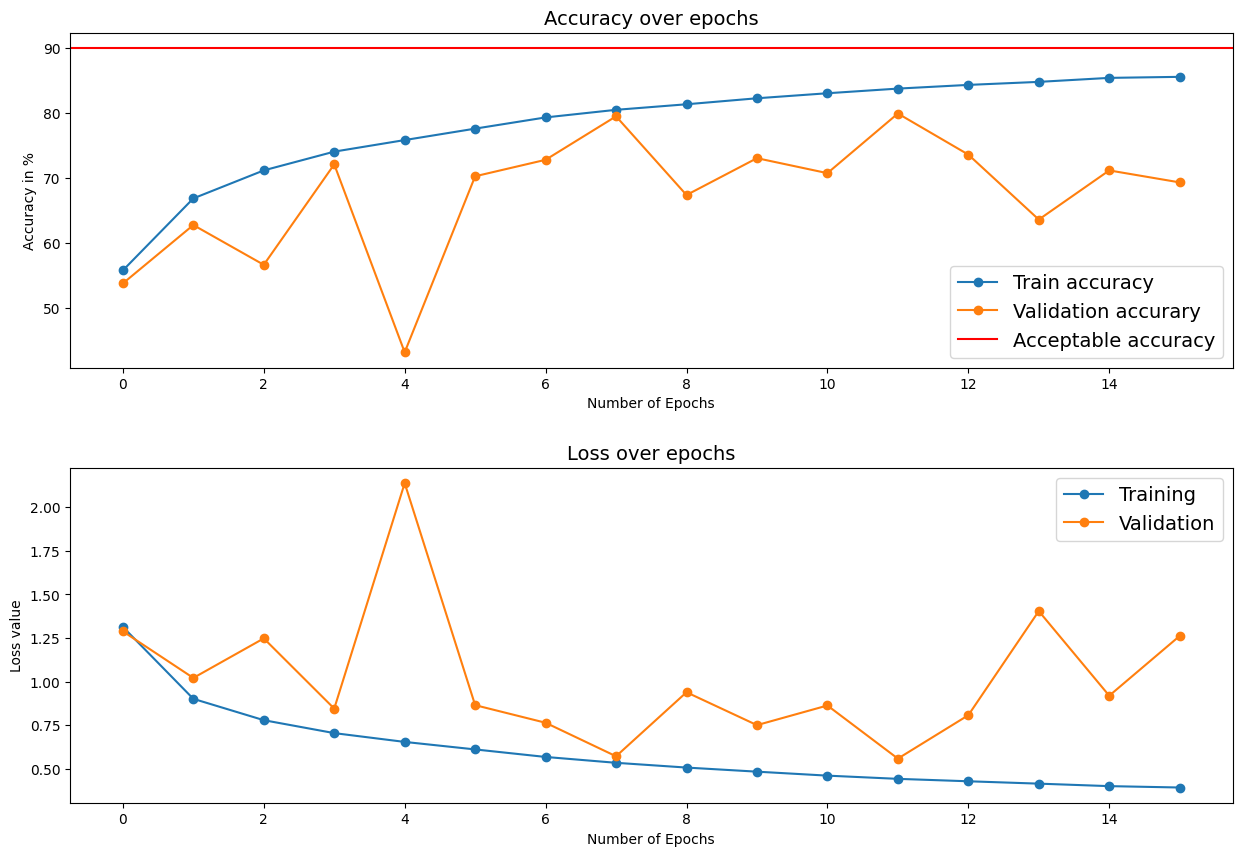

In [61]:
path = "best_model_min_val_loss.pth"
# Load model and plot training curves and compute test accuracy
### START CODE HERE ### (approx. 4 lines)
for i in [path, path2]:
  test_acc, test_loss = test_model(model_3, i, test_loader)
  print(f'Test Accuracy : {test_acc:.2f} \t || Loss {test_loss:.3f}')
plot_stats(dict_log, baseline=90, title='figs/exp_4_resnet_pathmnist.png')
### END CODE HERE ###

## Expected results

Model best_model_min_val_loss.pth is loaded from epoch 28 , loss 0.22461184859275818
Test acc 83.314735 , test loss 0.58688146

![exp_4_pathmnist_resnet.png](https://raw.githubusercontent.com/HHU-MMBS/Deep-Learning-Exercise-Extras/main/a07-08_mednist/figs/exp_4_pathmnist_resnet.png)


How is the train/val/test accuracies are related? What differences do you observe compared to using when scaling up to the larger dataset?

# Further reading
- [Skip connections](https://theaisummer.com/skip-connections/)
- [Why does batch norm work](https://www.youtube.com/watch?v=nUUqwaxLnWs)
